# 0) Work Directory and setup

In [1]:
import os
# Obtiene el nuevo directorio actual después del cambio
new_directory = '/Users/jyoung/Doctorado/embryo_classification/'
os.chdir(new_directory)
print("New actual directory:", new_directory)

# Elimino warnings molestas
import warnings
warnings.filterwarnings("ignore")

New actual directory: /Users/jyoung/Doctorado/embryo_classification/


# 1) Libraries

In [2]:
# Data Manipulation and Visualization
import numpy as np                  # NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt     # Matplotlib for creating visualizations
from pathlib import Path            # Pathlib for working with file paths
import openpyxl                     # Openpyxl for reading and writing Excel files
import json                         # JSON for data serialization
from tqdm import tqdm               # tqdm for creating progress bars
from typing import Tuple, List, Union  # Typing for type hinting in function signatures

# Model Training and Evaluation
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold  # Hyperparameter tuning and cross-validation
from sklearn.tree import DecisionTreeClassifier  # DecisionTreeClassifier for tree-based models
from sklearn.ensemble import RandomForestClassifier  # RandomForestClassifier for ensemble learning
from sklearn.metrics import confusion_matrix, accuracy_score  # Metrics for model evaluation
from sklearn.svm import SVC          # Support Vector Classification
from sklearn.neural_network import MLPClassifier  # Multi-layer Perceptron classifier
import xgboost as xgb               # XGBoost for gradient boosting
from sklearn.naive_bayes import GaussianNB  # Gaussian Naive Bayes classifier
from sklearn.decomposition import PCA  # Principal Component Analysis for dimensionality reduction
from sklearn.model_selection import train_test_split  # Splitting data for training and testing
from xgboost import plot_tree       # Plotting decision trees in XGBoost
from sklearn.model_selection import cross_val_score  # Cross-validation for model evaluation
from sklearn.model_selection import KFold  # K-Fold cross-validation

# Image Processing and Feature Extraction
from skimage.feature import graycomatrix, graycoprops  # Image texture features using co-occurrence matrix
from skimage import exposure         # Image exposure adjustment
from scipy import ndimage            # Multi-dimensional image processing
import skimage.measure              # Image measurement and analysis
from tensorflow.keras.preprocessing.image import img_to_array, load_img  # Image preprocessing using Keras
from PIL import Image

# Signal Processing
from scipy.signal import find_peaks, savgol_filter  # Signal processing functions in SciPy



###############
import torch
from skimage.transform import resize
from tensorflow.keras.applications import (
    VGG16, ResNet50, InceptionV3, MobileNetV2
)
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inceptionv3
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2
from tensorflow.keras.models import Model
import torchvision.transforms as T
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import cv2
from torch.utils.data import DataLoader

2023-11-25 19:18:59.976964: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2) Functions

## Image functions

In [3]:
def load_image(region: str, index: int) -> np.ndarray:
    """
    Loads and preprocesses an image from a specified region and index.

    Parameters:
    - region (str): Name of the region.
    - index (int): Index of the image.

    Returns:
    - chosen_region (np.ndarray): Preprocessed image.
    """
    chosen_region = img_to_array(load_img(str(region) + '/' + str(index) + '.bmp', grayscale=True)).squeeze() / 255.0
    return chosen_region


## Training functions

In [4]:
def apply_PCA(X, n_components):
    """
    Applies Principal Component Analysis (PCA) to the input data.

    Parameters:
    - X (array-like): Input data.
    - n_components (int): Number of components to keep.

    Returns:
    - X_pca (array-like): Transformed data after PCA.
    """
    # Apply PCA to the training set
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # Get the variance explained by each principal component
    explained_variance_ratio = pca.explained_variance_ratio_

    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Create the plot of cumulative variance
    plt.plot(range(1, n_components + 1), cumulative_variance, marker='o', linestyle='-', color='b')
    plt.title('Cumulative Variance of Principal Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance')
    plt.grid(True)
    plt.show()
    
    return X_pca


def run_halving_grid_search(X, y, clf, param_grid, scoring='accuracy', cv_splits=5, random_state=42, factor=3):
    """
    Runs a halving grid search for hyperparameter tuning.

    Parameters:
    - X (array-like): Input features.
    - y (array-like): Target variable.
    - clf: Classifier or regressor object.
    - param_grid (dict): Dictionary with hyperparameter names as keys and lists of hyperparameter settings to try.
    - scoring (str): Scoring metric for cross-validation (default is 'accuracy').
    - cv_splits (int): Number of cross-validation splits (default is 5).
    - random_state (int): Random seed for reproducibility (default is 42).
    - factor (int): Reduction factor for each iteration of halving (default is 3).

    Returns:
    - y_pred (array-like): Predicted labels.
    - accuracy (float): Mean accuracy across cross-validation folds.
    - std_dev (float): Standard deviation of accuracy across cross-validation folds.
    """
    # Create the StratifiedKFold object for stratified data splitting
    stratified_kf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    # Create the HalvingGridSearchCV object
    halving_grid_search = HalvingGridSearchCV(clf, param_grid, scoring=scoring, cv=stratified_kf, factor=factor)

    # Perform grid search with cross-validation
    tqdm(halving_grid_search.fit(X, y))

    # Get the best model from the grid search
    best_clf = halving_grid_search.best_estimator_

    # Print the best parameters found
    print("Best parameters:", halving_grid_search.best_params_)

    # Get cross-validation results
    cv_results = halving_grid_search.cv_results_

    # Print the mean value and standard deviation
    accuracy = np.mean(cv_results["mean_test_score"])
    std_dev = np.std(cv_results["mean_test_score"])
    print("\nMean Accuracy in cross-validation:", accuracy)
    print("Standard Deviation of Accuracy in cross-validation:", std_dev)

    # Predict labels on the full dataset (last iteration)
    y_pred = best_clf.predict(X)

    return y_pred, accuracy, std_dev


## Embedding functions

In [5]:
def flatten(lista):
    lista_aplanada = []
    [lista_aplanada.extend(sublista) for sublista in lista]
    return lista_aplanada


def obtener_embeddings_multi_redes(img_numpy, redes):
    # Redimensionar la imagen a 300x300
    img_resized = resize(img_numpy, (300, 300, 3), anti_aliasing=True)

    # Convertir a formato aceptado por las distintas redes
    img_preprocessed_vgg16 = preprocess_vgg16(img_resized)
    img_preprocessed_resnet50 = preprocess_resnet50(img_resized)
    img_preprocessed_inceptionv3 = preprocess_inceptionv3(img_resized)
    img_preprocessed_mobilenetv2 = preprocess_mobilenetv2(img_resized)

    # Expandir dimensiones para crear un lote de una sola imagen para cada red
    img_preprocessed_vgg16 = np.expand_dims(img_preprocessed_vgg16, axis=0)
    img_preprocessed_resnet50 = np.expand_dims(img_preprocessed_resnet50, axis=0)
    img_preprocessed_inceptionv3 = np.expand_dims(img_preprocessed_inceptionv3, axis=0)
    img_preprocessed_mobilenetv2 = np.expand_dims(img_preprocessed_mobilenetv2, axis=0)

    # Cargar las redes pre-entrenadas sin la capa de salida
    redes = [
        (redes[0], img_preprocessed_vgg16),
        (redes[1], img_preprocessed_resnet50),
        (redes[2], img_preprocessed_inceptionv3),
    ]

    embeddings = []
    for red, img_preprocessed in redes:
        embeddings_layer = red.output
        model = Model(inputs=red.input, outputs=embeddings_layer)
        embeddings.append(flatten(model.predict(img_preprocessed)))

    return embeddings

def extract_encoded_features(input_encoder, img):
    ### AGREGARLE SEGMENTACIÓN???
    with torch.no_grad():
        input_encoder.eval() 
        encoded_output = input_encoder.encoder(img)
        reshaped_tensor = encoded_output.view(-1) 
        list_tensor = reshaped_tensor.tolist()
    return list_tensor


## Autoencoder related classes

In [6]:
# Define la arquitectura del autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

class SmallerAutoencoder(nn.Module):
    def __init__(self):
        super(SmallerAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1),  # Reduciendo el número de canales
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=3, stride=2, padding=1),  # Reduciendo aún más los canales
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class EmbryoDataset(Dataset):
    def __init__(self, img_dir, numeric_labels):
        self.img_labels = numeric_labels
        self.img_dir = img_dir
        self.transform = T.Compose([
            T.Pad(100, padding_mode='reflect'),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(degrees=(-10, 10), fill=100),
            T.Resize((400, 400)),  # Ajustamos el redimensionamiento para un valor más cercano a 300x300
            T.CenterCrop(300),  # Aplicamos un recorte al tamaño final deseado
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(idx + 1) + '.BMP')
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir a RGB
        label = int(self.img_labels[idx])

        if self.transform:
            image = Image.fromarray(image)
            image = self.transform(image)

        return image, label


## Utility functions

In [7]:
def choose_region(zone, n_data, all_features, blast_quality):
  print(len(all_features[0]))
  X_data = np.zeros((n_data-1, len(all_features[0])))
  y_ICM = np.zeros(n_data-1)
  y_TE = np.zeros(n_data-1)
  y_ZP = np.zeros(n_data-1)


  for i in np.arange(1,n_data):
    y_ICM[i-1] = convert_to_number(blast_quality[i-1][1])
    y_TE[i-1] = convert_to_number(blast_quality[i-1][2])
    y_ZP[i-1] = convert_to_number(blast_quality[i-1][0])
    X_data[i-1] = all_features[i-1]

  if zone == 'ICM':
    y_data = y_ICM
  if zone == 'TE':
    y_data = y_TE
  if zone == 'ZP':
    y_data = y_ZP

  return X_data, y_data

def choose_region_autoencoder(zone, n_data, blast_quality):
  y_ICM = np.zeros(n_data-1)
  y_TE = np.zeros(n_data-1)
  y_ZP = np.zeros(n_data-1)

  for i in np.arange(1,n_data):
    y_ICM[i-1] = convert_to_number(blast_quality[i-1][1])
    y_TE[i-1] = convert_to_number(blast_quality[i-1][2])
    y_ZP[i-1] = convert_to_number(blast_quality[i-1][0])

  if zone == 'ICM':
    y_data = y_ICM
  if zone == 'TE':
    y_data = y_TE
  if zone == 'ZP':
    y_data = y_ZP

  return y_data

def convert_to_number(x):
    """
    Converts a label to its corresponding numeric value.

    Parameters:
    - x (str): Input label.

    Returns:
    - int: Numeric value corresponding to the input label.
    """
    if x == 'A':
        return 0
    if x == 'B':
        return 1
    if x == 'C':
        return 2

# 3) Embedding extraction

## Load CNNs

In [8]:
red_1 = VGG16(weights='imagenet', include_top=False)
red_2 = ResNet50(weights='imagenet', include_top=False)
red_3 = InceptionV3(weights='imagenet', include_top=False)

redes = [red_1, red_2, red_3]

## Load and train autoencoders

### Setup

In [9]:
n_data = 250
n_data = 5

# Define la función de pérdida y el optimizador
criterion = nn.MSELoss()
autoencoder = Autoencoder()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

region = 'ICM'
xlsx_file = Path('data/BlastsOnline', 'MasterlistAug30-2017.xlsx')
wb_obj = openpyxl.load_workbook(xlsx_file) 

sheet = wb_obj.active

blast_quality = []
for i in range(2,n_data+1):
    blast_quality.append(list(sheet['B'+str(i)].value))

y = choose_region_autoencoder(region, n_data, blast_quality)

img_dir = 'data/BlastsOnline/Images'

EmbryoDataset = EmbryoDataset(img_dir, y)


### Train autoencoder

In [10]:
# Crear DataLoader para cargar los datos en lotes
batch_size = 32  # Tamaño del lote, ajusta según tu preferencia
dataloader = DataLoader(EmbryoDataset, batch_size=batch_size, shuffle=True)

# Entrenamiento del autoencoder
num_epochs = 10  # Número de épocas, ajusta según sea necesario
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (inputs, _) in enumerate(dataloader):
        optimizer.zero_grad()
        print(inputs.shape)
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if batch_idx % 10 == 0:  # Imprimir cada cierto número de lotes
            print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(dataloader)}], Loss: {loss.item():.6f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {running_loss / len(dataloader):.6f}")


torch.Size([4, 3, 300, 300])
Epoch [1/10], Batch [1/1], Loss: 0.033221
Epoch [1/10], Average Loss: 0.033221
torch.Size([4, 3, 300, 300])
Epoch [2/10], Batch [1/1], Loss: 0.033085
Epoch [2/10], Average Loss: 0.033085
torch.Size([4, 3, 300, 300])
Epoch [3/10], Batch [1/1], Loss: 0.033028
Epoch [3/10], Average Loss: 0.033028
torch.Size([4, 3, 300, 300])
Epoch [4/10], Batch [1/1], Loss: 0.032919
Epoch [4/10], Average Loss: 0.032919
torch.Size([4, 3, 300, 300])
Epoch [5/10], Batch [1/1], Loss: 0.032824
Epoch [5/10], Average Loss: 0.032824
torch.Size([4, 3, 300, 300])
Epoch [6/10], Batch [1/1], Loss: 0.032698
Epoch [6/10], Average Loss: 0.032698
torch.Size([4, 3, 300, 300])
Epoch [7/10], Batch [1/1], Loss: 0.032551
Epoch [7/10], Average Loss: 0.032551
torch.Size([4, 3, 300, 300])
Epoch [8/10], Batch [1/1], Loss: 0.032522
Epoch [8/10], Average Loss: 0.032522
torch.Size([4, 3, 300, 300])
Epoch [9/10], Batch [1/1], Loss: 0.032265
Epoch [9/10], Average Loss: 0.032265
torch.Size([4, 3, 300, 300])

### Train small autoencoder

In [11]:
# Define la función de pérdida y el optimizador
criterion = nn.MSELoss()
small_autoencoder = SmallerAutoencoder()
optimizer = optim.Adam(small_autoencoder.parameters(), lr=0.001)

# Entrenamiento del autoencoder
num_epochs = 10  # Número de épocas, ajusta según sea necesario
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (inputs, _) in enumerate(dataloader):
        optimizer.zero_grad()
        print(inputs.shape)
        outputs = small_autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if batch_idx % 10 == 0:  # Imprimir cada cierto número de lotes
            print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(dataloader)}], Loss: {loss.item():.6f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {running_loss / len(dataloader):.6f}")


torch.Size([4, 3, 300, 300])
Epoch [1/10], Batch [1/1], Loss: 0.036198
Epoch [1/10], Average Loss: 0.036198
torch.Size([4, 3, 300, 300])
Epoch [2/10], Batch [1/1], Loss: 0.036071
Epoch [2/10], Average Loss: 0.036071
torch.Size([4, 3, 300, 300])
Epoch [3/10], Batch [1/1], Loss: 0.036033
Epoch [3/10], Average Loss: 0.036033
torch.Size([4, 3, 300, 300])
Epoch [4/10], Batch [1/1], Loss: 0.035949
Epoch [4/10], Average Loss: 0.035949
torch.Size([4, 3, 300, 300])
Epoch [5/10], Batch [1/1], Loss: 0.035864
Epoch [5/10], Average Loss: 0.035864
torch.Size([4, 3, 300, 300])
Epoch [6/10], Batch [1/1], Loss: 0.035749
Epoch [6/10], Average Loss: 0.035749
torch.Size([4, 3, 300, 300])
Epoch [7/10], Batch [1/1], Loss: 0.035715
Epoch [7/10], Average Loss: 0.035715
torch.Size([4, 3, 300, 300])
Epoch [8/10], Batch [1/1], Loss: 0.035638
Epoch [8/10], Average Loss: 0.035638
torch.Size([4, 3, 300, 300])
Epoch [9/10], Batch [1/1], Loss: 0.035533
Epoch [9/10], Average Loss: 0.035533
torch.Size([4, 3, 300, 300])

## Extract features

In [13]:
features_ICM = []
features_TE = []
features_ZP = []
all_features = []

for index in np.arange(1, n_data):
    print(index)
    img_ICM = load_image('data/BlastsOnline/GT_ICM', index)
    img_TE = load_image('data/BlastsOnline/GT_TE', index)
    img_ZP = load_image('data/BlastsOnline/GT_ZP', index)
    img_Blast = load_image('data/BlastsOnline/Images', index)

    rgb_ICM = np.stack((img_ICM*img_Blast,) * 3, axis=2)
    rgb_TE = np.stack((img_TE*img_Blast,) * 3, axis=2)
    rgb_ZP = np.stack((img_ZP*img_Blast,) * 3, axis=2)

    images = [rgb_ICM, rgb_ZP, rgb_TE]

    # Obtener los embeddings
    embeddings_ICM = obtener_embeddings_multi_redes(images[0], redes)[0]
    embeddings_ICM_reshaped = np.array(embeddings_ICM).reshape(-1)
    embeddings_TE = obtener_embeddings_multi_redes(images[1], redes)[0]
    embeddings_TE_reshaped = np.array(embeddings_TE).reshape(-1)
    embeddings_ZP = obtener_embeddings_multi_redes(images[2], redes)[0]
    embeddings_ZP_reshaped = np.array(embeddings_ZP).reshape(-1)

    tensor_Blast, _ = EmbryoDataset.__getitem__(index-1)
    autoencoder_embeddings = extract_encoded_features(autoencoder, tensor_Blast)
    small_autoencoder_embeddings = extract_encoded_features(small_autoencoder, tensor_Blast)

    total_embeddings = np.hstack((embeddings_ICM_reshaped,
                                  embeddings_TE_reshaped,
                                  embeddings_ZP_reshaped,
                                  autoencoder_embeddings,
                                  small_autoencoder_embeddings))

    features_ICM.append(embeddings_ICM_reshaped)
    features_TE.append(embeddings_TE_reshaped)
    features_ZP.append(embeddings_ZP_reshaped)
    all_features.append(total_embeddings)
    

1
1/1 [==============================] - 1s 710ms/step
2
1/1 [==============================] - 1s 714ms/step
3
1/1 [==============================] - 1s 705ms/step
4
1/1 [==============================] - 1s 725ms/step


In [14]:
total_embeddings

array([0.        , 0.        , 0.        , ..., 0.082334  , 0.08229096,
       0.08264872])

## Save features

In [ ]:

# Convert NumPy arrays within lists to nested lists
features_ICM_list = [arr.tolist() for arr in features_ICM]
features_TE_list = [arr.tolist() for arr in features_TE]
features_ZP_list = [arr.tolist() for arr in features_ZP]

# Save the nested lists in JSON files
with open('data/embedded_features/features_ICM.json', 'w') as archivo_json:
    json.dump(features_ICM_list, archivo_json)

with open('data/embedded_features/features_TE.json', 'w') as archivo_json:
    json.dump(features_TE_list, archivo_json)

with open('data/embedded_features/features_ZP.json', 'w') as archivo_json:
    json.dump(features_ZP_list, archivo_json)

# To load the data back
with open('data/embedded_features/features_ICM.json', 'r') as archivo:
    loaded_data = json.load(archivo)
    features_ICM = [np.array(arr) for arr in loaded_data]

with open('data/embedded_features/features_TE.json', 'r') as archivo:
    loaded_data = json.load(archivo)
    features_TE = [np.array(arr) for arr in loaded_data]

with open('data/embedded_features/features_ZP.json', 'r') as archivo:
    loaded_data = json.load(archivo)
    features_ZP = [np.array(arr) for arr in loaded_data]


# 4) Load labels

In [ ]:
xlsx_file = Path('data/BlastsOnline', 'MasterlistAug30-2017.xlsx')
wb_obj = openpyxl.load_workbook(xlsx_file) 

sheet = wb_obj.active

blast_quality = []
for i in range(2,n_data+1):
    blast_quality.append(list(sheet['B'+str(i)].value))

In [ ]:


X,y = choose_region('ICM', n_data, all_features, blast_quality)

124416
(29, 124416)
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29


In [ ]:
# Sanity check:

print(len(X) == n_data-1)

print(len(y) == n_data-1)

True
True


# 6) Entrenamiento

## Principal component analysis

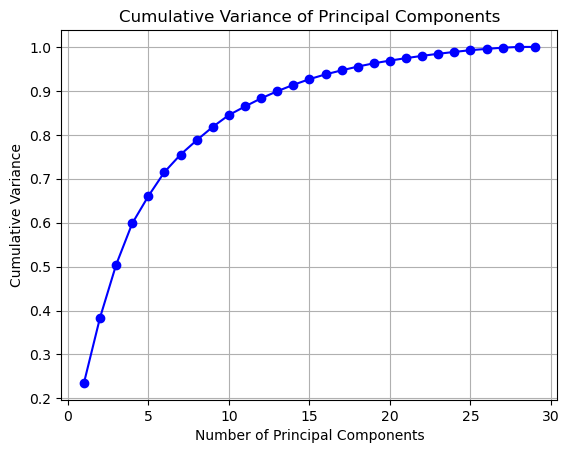

In [ ]:
X_pca = apply_PCA(X, 29)

## Decision Tree

In [ ]:
# Definir un espacio de búsqueda más amplio para la búsqueda de cuadrícula


param_grid = {
    'max_depth': [None, 3, 5, 8, 10],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8, 12],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_leaf_nodes': [None, 10, 20, 30],
    'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3],
    'class_weight': [None, 'balanced']
}

param_grid = {
    'max_depth': [None, 3, 5, 8, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]
}


clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)

output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

0it [00:00, ?it/s]


Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}

Mean Accuracy in cross-validation: 0.5095138888888889
Standard Deviation of Accuracy in cross-validation: 0.098992586664387


0it [00:00, ?it/s]

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20}

Mean Accuracy in cross-validation: 0.5199305555555556
Standard Deviation of Accuracy in cross-validation: 0.09936019767076172


## Random Forest

In [ ]:
clf = RandomForestClassifier(class_weight='balanced', random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_samples': [None, 0.8, 0.9, 1.0],  # Solo para bootstrap=True
    'oob_score': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

KeyboardInterrupt: 

## SVM

In [ ]:
clf = SVC(class_weight='balanced', random_state=42)

# Definir el espacio de búsqueda

param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 1e-3, 1e-4],
    'degree': [2, 3, 4],  # Solo para kernel 'poly'
    'coef0': [0.0, 0.1, 1.0]  # Solo para kernel 'poly' y 'sigmoid'
}

param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}


output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

0it [00:00, ?it/s]


Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Mean Accuracy in cross-validation: 0.5111111111111111
Standard Deviation of Accuracy in cross-validation: 0.03142696805273544


0it [00:00, ?it/s]

Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

Mean Accuracy in cross-validation: 0.48055555555555557
Standard Deviation of Accuracy in cross-validation: 0.08328702416980527


## Naive bayes

In [ ]:
# Crear el clasificador Naive Bayes
clf = GaussianNB()

# Definir el espacio de búsqueda
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
}

output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

0it [00:00, ?it/s]


Best parameters: {'var_smoothing': 0.1}

Mean Accuracy in cross-validation: 0.5466666666666666
Standard Deviation of Accuracy in cross-validation: 0.03231786571610885


0it [00:00, ?it/s]

Best parameters: {'var_smoothing': 0.1}

Mean Accuracy in cross-validation: 0.27666666666666667
Standard Deviation of Accuracy in cross-validation: 0.019999999999999997


## XGBoost

In [ ]:
# Crear el clasificador XGBoost
clf = xgb.XGBClassifier(random_state=42)

# Definir el espacio de búsqueda
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 1, 10],
}


output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

KeyboardInterrupt: 

Epoch [1/10], Batch [1/8], Loss: 0.033105
Epoch [1/10], Average Loss: 0.028004
Epoch [2/10], Batch [1/8], Loss: 0.033223
Epoch [2/10], Average Loss: 0.025637
Epoch [3/10], Batch [1/8], Loss: 0.025919
Epoch [3/10], Average Loss: 0.022791
Epoch [4/10], Batch [1/8], Loss: 0.024989
Epoch [4/10], Average Loss: 0.020510
Epoch [5/10], Batch [1/8], Loss: 0.020044
Epoch [5/10], Average Loss: 0.018689
Epoch [6/10], Batch [1/8], Loss: 0.013308
Epoch [6/10], Average Loss: 0.017525
Epoch [7/10], Batch [1/8], Loss: 0.014450
Epoch [7/10], Average Loss: 0.016816
Epoch [8/10], Batch [1/8], Loss: 0.018650
Epoch [8/10], Average Loss: 0.016208
Epoch [9/10], Batch [1/8], Loss: 0.016931
Epoch [9/10], Average Loss: 0.015289
Epoch [10/10], Batch [1/8], Loss: 0.014667
Epoch [10/10], Average Loss: 0.014337
